# Artistic Neural Style Transfer

In [19]:
# Importing the libraries
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [20]:
# Checking and choosing the device on which the network is to be run
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
# Setting the size of output image based on device
imsize = 512 if torch.cuda.is_available() else 128 # smaller size for cpu to ease computation

In [22]:
loader = transforms.Compose([
    transforms.Resize((imsize,imsize)), # scale the imported image to the required dimensions
    transforms.ToTensor() # transform the image into tensor
])

def image_loader(image_name):
    """ Loads the image from the given pathname/name
        Performs the transformation of resizing and converts it into tensor
        Adds a dimension to the picture which acts as a fake batch dimension
    """
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

In [23]:
# Defining the style image
path1 = "/content/style2.jpeg"
style_img = image_loader(path1)
print("Size of style image  ==> ", style_img.size())

# Defining the content image
path2 = "/content/content1.jpg"
content_img = image_loader(path2)
print("Size of content image ==> ", content_img.size())

# Checking and ensuring the fact that the images are of same scene
assert style_img.size() == content_img.size()
    # "we need to import style and content images of the same size"




Size of style image  ==>  torch.Size([1, 3, 512, 512])
Size of content image ==>  torch.Size([1, 3, 512, 512])


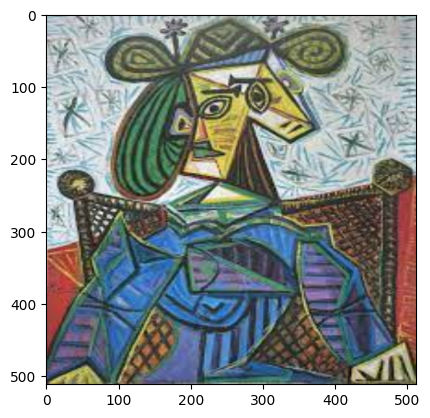

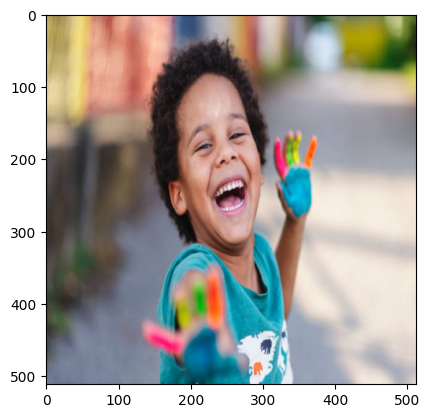

In [24]:
unloader = transforms.ToPILImage()
plt.ion() # Making the plot interactive

def imshow(tensor, title = None):
    """ Method to display the image in form of matplotlib plot
    """
    image = tensor.cpu().clone()
    image = image.squeeze(0)

    image = unloader(image)
    plt.imshow(image)
    plt.pause(0.001)

# Displaying Style Image
plt.figure()
imshow(style_img, title='Style Image')

# Displaying Content Image
plt.figure()
imshow(content_img, title='Content Image')

In [25]:
# Module defining the Content loss
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        # the target is 'detach'ed content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [26]:
def gram_matrix(input):
    """ The function that generates the gram matrix corresponding to an image
    """
    a, b, c, d = input.size()
    # a = batch size (= 1)
    # b = number of feature maps
    # c, d are the dimensions of each feature map
    features = input.view(a*b, c*d)

    # Computing the Gram Matrix
    G = torch.mm(features, features.t())

    # Normalizing the Gram Matrix
    return G.div(a*b*c*d)

In [27]:
# Module defining the Style Loss
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        # the gram matrix of target is 'detach'ed content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [28]:
# Importing the model
cnn = models.vgg19(pretrained=True).features.to(device).eval()

# PyTorch Implementation of VGG-19 has two child module and features contains
# convolutional layers and pooling layers. To prevent layers having different
# behaviour the network is set to eval mode.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:08<00:00, 64.0MB/s]


In [29]:
# VGG Network is trained on images with each channel normalized by below mentioned mean and std
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [30]:
# Defining the layers for style and content

# Content Layers
content_layers_default = ['conv_4']

# Style Layers
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

In [31]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    """
    This function returns the model, the style loss and the content loss
    """
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # Initializing the losses
    content_losses = []
    style_losses = []

    # Initialzing the model with a sequential layer
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # Removig the last layers
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

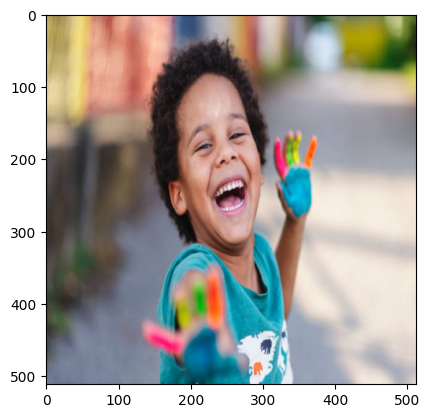

In [32]:
# Generating input image.
# In this case input image is same as content image
# White noise can also be used
input_img = content_img.clone()

# Displaying the input image
plt.figure()
imshow(input_img, title='Input Image')

In [33]:
# Getting the optimizer for gradient descent
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [34]:
# The main function that performs the artistic neural style tranfer
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # In place clamping
            input_img.data.clamp_(0, 1)

            # Setting the gradient to 0
            optimizer.zero_grad()

            # Passing the input image through the model
            model(input_img)

            # Initializing the style score and content score
            style_score = 0
            content_score = 0

            # Incrementing the losses
            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            # Factoring in the style weight and content weight
            style_score *= style_weight
            content_score *= content_weight

            # Getting the loss
            loss = style_score + content_score

            # Taking the backward step
            loss.backward()

            # Printing the loss after every 50 steps
            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # The last correction
    input_img.data.clamp_(0, 1)

    return input_img

Building the style transfer model..


<ipython-input-29-27deac09f365>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-29-27deac09f365>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Optimizing..
run [50]:
Style Loss : 29.330698 Content Loss: 13.022994

run [100]:
Style Loss : 9.384276 Content Loss: 12.695889

run [150]:
Style Loss : 5.376506 Content Loss: 11.857281

run [200]:
Style Loss : 3.128911 Content Loss: 11.227112

run [250]:
Style Loss : 2.021484 Content Loss: 10.771344

run [300]:
Style Loss : 1.503086 Content Loss: 10.367014



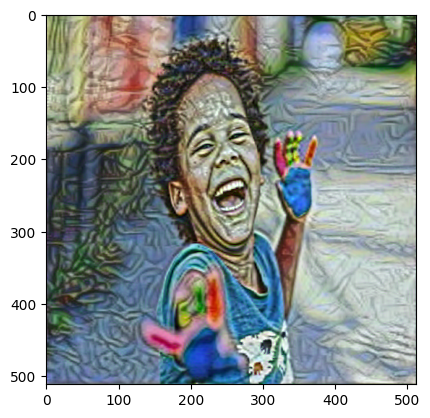

In [35]:
# Running the style transfer and getting the output
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

# Displaying the output
plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()


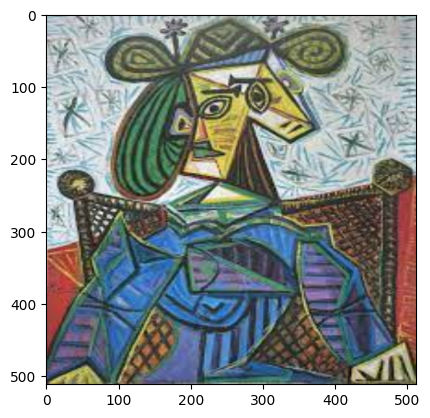

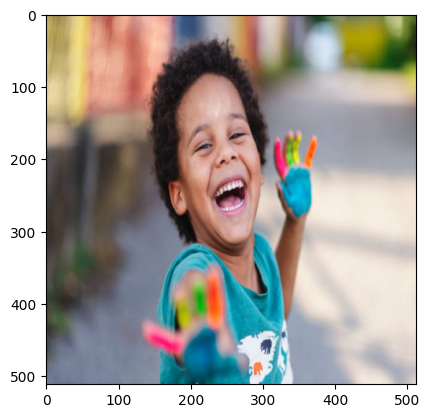

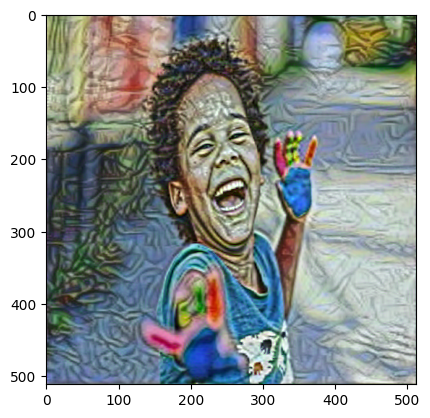

In [36]:
plt.figure()
imshow(style_img, title='Style Image')

# Displaying Content Image
plt.figure()
imshow(content_img, title='Content Image')
plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()